<a href="https://colab.research.google.com/github/souzajvp/hands-on-ML/blob/main/posts/pt_br/Como_criar_um_modelo_classificat%C3%B3rio_perfeito_ou_quase_isso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Um problema de classificação
Você já deve ter ouvido falar que os principais tipos de tarefas enfrentados por modelos de *machine learning* (ML) são **classificação** e **regressão**.

Vamos deixar a regressão para outro dia e focar nos meus problemas favoritos, os de **classificação!** 

Como o próprio nome diz, um modelo de classificação tem como objetivo prever a  classe de certo item de interesse, por exemplo:
1. Classificar um e-mail em spam ou não-spam;
2. Classificar um paciente em diabético ou não diabético;
3. Classificar uma foto de um animal em gato, cachorro ou cavalo¹.

¹Os modelos para reconhecimento de imagens são mais complexos do que isso, pricipalmente quando usamos redes neurais e *deep learning* para resolver esse tipo de tarefa.

# Chega de conversa, vamos por a mão na massa.
Nesse pequeno exemplo, vamos criar um modelo de ML capaz de prever a qual dígito (considerando as possibilidades de 0 a 9) uma imagem pertence¹.

Se você leu o título desse notebook, eu **prometi criar um modelo perfeito**... calma! Logo mais falaremos disso!

¹Trata-se do dataset [MNIST](http://yann.lecun.com/exdb/mnist/), um banco de dados muito usado por quem está aprendendo! Basicamente esse banco consiste de informações de 70.000 imagens que representam dígitos de 0-9.
***
**Nota**: O modelo que criaremos é um modelo **superivisionado**, ou seja, ao treinar o modelo, também informamos qual é a classe real que cada entrada de dados pertence. Existem outros tipos de modelos como os **não supervisionados** e também os **semi-supervisionados**. Cada um tem suas vantanges e desvatangens!

## Importando o banco de dados

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

O banco MNIST pode ser obtido diretamente através da biblioteca Sickit-Learn. Essa biblioteca é muito usada e reconhecida para projetos de machine learning em python.

## Separando as variáveis (ou atributos) e o alvo de predição
Para facilitar a nossa vida, o banco MNIST já vem separado em:
1. `data` - fragmento contendo as variáveis;
2. `target` - fragmento que contém a classe de cada variável 

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Aqui temos a nossa matrix X (que contém as variáveis) e o vetor y (que contém as classificações dos dígitos).

**Vocês podem estar se perguntando**: "Por que temos o formato (70000, 784) para nossa matriz X"?

Na verdade as 784 colunas representam os valores de cada pixel presente na imagem original. Cada uma delas era composta por 28 x 28 pixels. Cada um deles recebe um valor de acordo com a intensidade de core presente.


## Vamos dar uma olhada nos dígitos para entender melhor a situação;

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

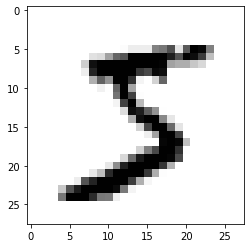

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.show()

Nessa figura "pixelada" vemos algo que se parece com um 5. O que fizemos foi usar funções do `numpy` e `matplotlib` para transformar todas as 784 colunas do primeiro dígito do nosso banco novamente no formato 28 x 28.

Em seguida, usamos o `plt.imshow()` vara visualizar a imagem em seu novo formato.¹

¹Notem que ainda podemos ver nos eixos x e y, os números dos pixels da imagem!

Só para confirmar, vamos verificar se essa imagem era de um 5 mesmo.

In [7]:
y[0]

'5'

De fato, esse "garrancho" representa um 5. 

**Opa!** Notamos algo importante ali em cima. O alvo do nosso modelo (y) está tipificado como **string**. Vamos mudar o tipo para int

In [8]:
import numpy as np
np.random.seed(42)
y = y.astype(np.uint8)

### Nosa tarefa é classificar as imagens é digitos. Parece simples, não?
Bom... não

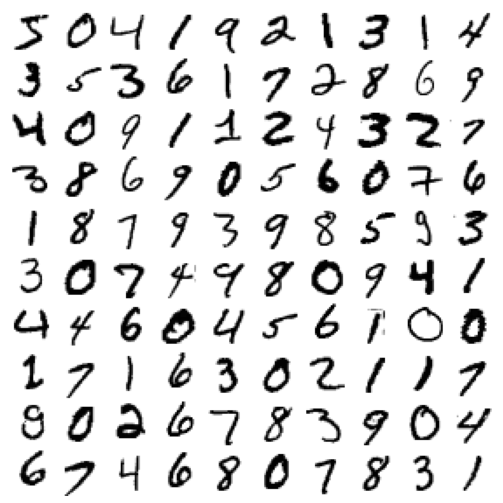

In [9]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

Na figura acima notamos com os dígitos não seguem um padrão determinado. Na verdade, as 70.000 images presentes nesse banco foram escritas por diversas pessoas. Assim, pode ser difícil classificar os dígitos da forma correta.

### Certo então vamos começar com o treinamento dos modelos!

Antes de começarmos, é sempre importante separamos nossos fragmentos de **treino** e **teste**.

Se você é novo nesse mundo de ML, saiba que realizar esse tipo de abordagem é algo rotineiro pra quase todas as abordagens. <br>
**Aí vão algumas explicações para essa conduta**:
1. Ao treinar um modelo usando todos os seus dados, fica impossível avaliar se o modelo não está com *overfitting*. 

Usando uma analogia simples, um modelo com *overfitting* é como um **aluno que decorou todas as respostas da lista de exercícios** para a prova. Se caírem apenas questões que estavam presentes na lista de exercícios, o aluno vai tirar 10. Agora, **se as questões forem diferentes**... "ferrou"!

2. Fica difícil avaliar se o modelo esta tendo *underfitting*. Este seria o contrário do termo anterior. Ou seja, o modelo não está "compreendendo" a relação entre as variáveis e a classificação. Isso provavelmente acarretaria em um modelo ruim em prever sobre novos dados.

De forma geral:
* Com o conjunto de **treino**, vamos realizar o treinamento do modelo. Em seguida, podemos avaliar o quão eficaz nosso modelo está para prever as classes usadas para treiná-lo.
* Com o conjunto de **teste**, vamos "testar" (duh!) o modelo. Isso serve como uma noção de como nosso modelo se comportaria no mundo real, com dados nunca vistos!

Outra vantagem do banco MNIST dentro da biblioteca Sckit-Learn, é que ele já vem organizado entre treino e teste. Basta fazermos a seguinte separação.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

O conjunto de dados mnist tem 10 dígitos possíveis (0-9). Antes de começarmos a trabalhar com uma classificação de dez classes, por que não começar com uma tarefa mais simples?

## Treinando um classificador binário
Esta é uma simplificação do nosso problema ... Aqui vamos criar o modelo "**Detector de cincos**". Basicamente, o que queremos alcançar é a capacidade de classificar nossos dígitos em **5** ou **não-5**!
***
Neste caso, podemos usar um modelo classificador como o modelo **Stochastic Gradient Descent** (SGD)!
Este modelo é interessante porque consegue lidar com bancos grandes, de forma rápda. 

Curiosamente, SGD não pertence a uma família específica de modelos de ML. Ele é mais **uma técnica de otimização** do que um modelo em si. Este classificador é capaz de trabalhar com matrizes esparsas, o que também agiliza tudo.

As vantagens do SGD são:
* Eficiência.
* Facilidade de implementação.

> [Documentação SGD](https://scikit-learn.org/stable/modules/sgd.html)

Separando os conjuntos de 5 e não 5

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

Instanciando o modelo e realizando o processo de treino ('fit')

In [13]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Agora que treinamos nosso modelo, vamos avaliar se ele ficou bom!

In [14]:
print(sgd_clf.predict([some_digit]))
print(y[0])

[ True]
5


E aí está! Nosso modelo preveu **True** para o primeiro dígito na nossa base e de fato esse dígito era um 5!
<br>
<br>

Mas calma lá! Uma única previsão não é suficiente para batermos o martelo!

## Métricas para avaliação de um classificador binário
Avaliar um modelo de classificação pode ser um pouco complicado¹! Vamos lá!

¹Um modo de avaliarmos nosso modelo de forma eficaz é atravez do método de **validação cruzada** (ou *cross-validation* para os íntimos). 
***
Eu não vou entrar nos detalhes da validação cruzada por aqui, mas para nós basta saber que esse método executa vários testes para obter uma média dos resultados. Além disso, podemos separar nossos conjunto de treino em mais um conjunto, o de **validação**. 

O método de validação cruzada é ótimo para estudarmos o comportamento do nosso modelo de forma mais fidedígna

In [15]:
from sklearn.model_selection import cross_val_score

No primeiro momento, vamos avaliar a **acurácia** do nosso modelo.

In [16]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy',
               n_jobs=-1)

array([0.95035, 0.96035, 0.9604 ])

Uau! Segundo os resultados acima, obtivemos **aproximadamente 95% de acurácia** nos 3 testes realizados!

<font color='red'> >> </font> **Eu não falei que iríamos criar um modelo perfeito!???**

**Calma lá!** Um boa regra pra trabalhar com modelos de ML é desconfiar dos seus resultados. **Principalmente se você obtiver um resultado ótimo logo de cara!**!!!!

Para mostrar como nosso modelo não é lá essas coisas, vamos criar um modelo que chuta "**Não-5**" para tudo que vê pela frente

In [17]:
from sklearn.base import BaseEstimator
# Apesar de parecer complexo, o código abaixo cria uma classe similar aos modelos 
# da biblioteca skearn que retorna uma matriz cheia de zeros, considerando o tamanho
# dos dados usados. O 0 é transformado em False e portanto temos previsões "Não-5"
# para todos os dados

class ClassificadorNunca5(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = ClassificadorNunca5()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

**Tchã-ram** !! Adivinhando **não-5** todas as vezes, obtemos precisões **próximas a 91% todas as vezes**.

Isso acontece porque temos 10 dígitos possíveis em nosso conjunto de dados. Nesse sentido, 90% dos nossos dados já são da classe **não 5**!!!
***
Este resultado também nos diz por que a **precisão** geralmente não é a melhor métrica para avaliar classificadores. Essa métrica se torna ainda pior quando seus dados não têm o mesmo número de instâncias para cada classe!

Esse problema também é chamado de *desbalanço de classes* e é definitivamente importante no treinamento de modelos de classificadores.

### Matriz de confusão
A matriz de confusão pode ser bastante útil para se ter uma ideia geral do desempenho de nosso modelo. O que ela faz é comparar um conjunto de previsões e mostrar quantas delas você acertou ou errou.

Pra isso, podemos usar a função `cross_val_predict` do Sklearn.

In [19]:
from sklearn.model_selection import cross_val_predict

In [20]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                                n_jobs=-1)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [21]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_train_5, y_train_pred)
cf_matrix

array([[53892,   687],
       [ 1891,  3530]])

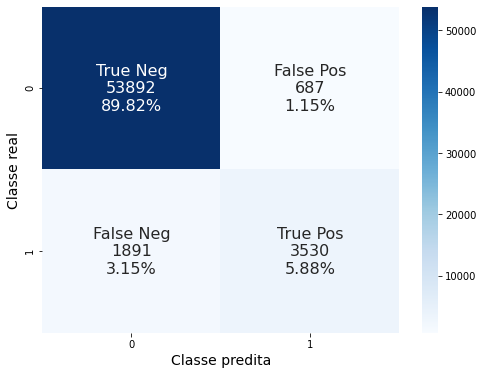

In [22]:
import seaborn as sns

def plot_nice_cm(matrix, fig_save_name=None):
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = [str(value) for value in matrix.flatten()]
    group_percentages = [f'{value:0.2%}' for value in matrix.flatten()/np.sum(matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(matrix, annot=labels, fmt='',
               cmap='Blues', ax=ax, annot_kws={"fontsize":16})
    ax.set_ylabel('Classe real', fontsize=14)
    ax.set_xlabel('Classe predita', fontsize=14)
    if fig_save_name:
        fig.savefig(fig_save_name, dpi=150, bbox_inches='tight')

plot_nice_cm(cf_matrix)

Na figura acima podemos avaliar a performance do modelo usando os conjuntos de treino e validação dentro do método `cross_val_predict`.

**O modelo acertou!**
1. **True negative** - 53892 (82% dos dados) eram realmente **negativos** e foram previstos como **negativos**;
2. **Ture positives** - 3530 (5.88%) eram realmente **positivos** e foram previstos como **positivos**.

**O modelo errou!**
3. **False negative** - 1891 (3.15% dos dados) eram realmente **negativos** mas foram previstos como **positivos**  
4. **False positive** - 687 (1.15% dos dados) eram realmente **negativos** mas foram previstos como **positivos**;

Pode parecer que nosso modelo está muito bom, já que teve uma proporção de erros bem mais baixa do que a de acertos, porém é sempre importante lembrar do nosso modelo `ClassificadorNunca5()`!

## Métricas para avaliar um classificador binário
Como vimos nos tópicos acima, usar apenas a acurácia como métrica de avaliação de um modelo classificatório pode não ser a melhor estratégia.

Na verdade, o ideal é trabalharmos com mais de uma métrica e semprea avaliarmos o balanço entre elas para avaliar nosso modelo.

**Precisão/exatidão/valor preditivo positivo (PPV)** <br>

Esse índice nos dá uma ideia sobre a precisão das previsões positivas, ou seja, a *proporção de resultados verdadeiramente positivos em comparação com todos os resultados positivos* que você obteve. <br>
$ precision = \frac{VP}{VP + FP} $¹

**Recall/sensibilidade/taxa de verdadeiro positivo (TPR)** <br>

A proporção de instâncias positivas que são detectadas corretamente pelo classificador em comparação com todos os valores positivos reais que você tem. <br>
$ recall = \frac{VP}{VP + FN}$²

¹VP = Verdadeiro positivo; FP = Falso positivo <br>
²VP = Verdadeiro positivo; FN = Falso negativo
***
**Isso parece muito confuso, né?**

Vamos tentar entender melhor através de um exemplo simples: você tem uma cesta de frutas contendo 10 laranjas (🍊) e 10 maçãs (🍎).

Lhe pediram que você pegasse todas as maçãs. Você pegou 12 frutas aleatoriamente e selecionou 7 🍊 e 5 🍎.

1. Você selecionou apenas 5 maçãs, considerando o total possível de 10. Isso representa o seu **recall**!

Ou seja (5/10) * 100 = **50% de recall nesse caso**. "*Eu queria pegar 10 maçãs, mas só consegui 5*".

2. Das 12 frutas que você selecionou, apenas 5 eram maçãs. Isso é a sua **precision**!

Ou seja (5/12) * 100 = **41.7% de precision nesse caso**. "*Eu peguei 12 frutas, mas só 5 eram maçãs*"


### Agora vamos aplicar essas métricas no nosso modelo

In [23]:
from sklearn.metrics import precision_score, recall_score

In [24]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

<font color='blue'> >> </font> Quando nosso modelo diz que um dígito é 5, ele **está certo cerca de 83% das vezes**!

In [25]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

<font color='blue'> >> </font> E ainda pior, de forma geral, nosso **modelo foi capaz de detectar apenas 65% dos números 5** presentes no nosso banco de dados!

## O balanço entre a precisão e o recall
Infelizmente, não se pode ter tudo na vida. Com a *precision* e o *recall*, também é assim!

De certa forma, essas duas métricas costumam ter uma relação inversa. Se uma sobe, outra cai e vice-versa. Assim, para cada projeto e para cada objetivo temos que pensar em o que é mais importante:
1. Garantir uma alta *precision*?
2. Tentar obter um alto *recall*?

Para visualizar esse *trade-off*, vamos olhar a figura a seguir!

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

In [27]:
from sklearn.metrics import precision_recall_curve

In [28]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

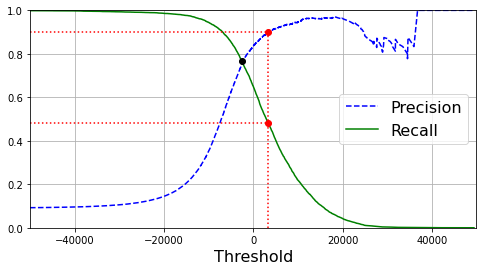

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])  
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_70_precision = thresholds[np.argmax(precisions >= 0.75)]
recall_70_precision = recalls[np.argmax(precisions >= 0.75)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")      
plt.plot([threshold_70_precision], [recall_70_precision], "ko")                                                                         


plt.show()

Na figura acima notamos claramente que o comportamento da precision e do recall são inversos. Com os pontos em <font color='red'> vermelho </font> temos: Ponto superior: valor em que teríamos 90% de precisão, o que nos levaria a um recall de ~50% (ponto inferior).

**Obs:** Se estivéssemos procurando por um equilíbrio entre as métricas, talvez poderíamos escolher o ponto em que as curvas se cruzam em **preto**.

# Conclusões
A partir dessa pequena discussão, vimos que:
1. **Temos que tomar cuidado com a abordagem que tomamos para resolver os problemas com machine learning.** 

Como exemplificado aqui, de que adianta um modelo com ~95% de acurácia em dizer se um número é um **cinco** se apenas chutarmos **não-cinco** para todos teremos uma acurácia de ~91%?

2. **Avaliar um modelo classificatório pode ser bem mais complexo do que um modelo regressor.**

Como disse nos exemplos acima, temos métricas como o recall e precision que são frequentemente usadas. Mesmo assim, não é raro fazermos confusão entre elas. Não mencionei aqui, mas existem outras métricas importantes como a AUC.

3. **Não existe uma fórmula secreta para modelos classificatórios.**

Cada projeto terá um objetivo diferente. Em certas ocasiões você pode optar por um recall maior, tentando reduzir ao máximo os falsos negativos. Em outras, uma precision maior pode ser necessária.



# Perspectivas
1. Treinar um modelo realmente capaz de diferenciar os 10 dígitos presentes no nosso banco de dados!